In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import os
import xgboost as lgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=3

In [3]:
print FOLD

3


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz",
                                     with_l2=True,with_l3=True,with_l4=True,with_l5=True)
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

0

# cv

In [9]:
n_reg_lookback=7
n_lookforward=1
n_offset=0

In [10]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 
                'visitor_ma7', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 
                'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 
                'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'geo2_visitors_mean', 
                'station_visitors_mean', 'geo2_count_y1', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 
                'station_count_y3', 'station_count_y4',
               's16_y_nan', 's16_y_std', 's16_y1_ratio', 's16_y2_ratio',
               'bad_ratio'])
len(lag_cols)

32

In [11]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [12]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean',
                    '3003nb_conv_fold{}_False_d478.pkl', '3005_rf_fold{}_False_d478.pkl', '3001eb_lgb_fold{}_True_d478.pkl', '3002nb_lstm_fold{}_False_d478.pkl', '3000eb_ridge_fold{}_True_d478.pkl', '3002_lstm_fold{}_False_d478.pkl', '3006_xgb_fold{}_False_d478.pkl', '3003_conv_fold{}_False_d478.pkl', '3000_ridge_fold{}_False_d478.pkl', '3001_lgb_fold{}_False_d478.pkl'                                                            ,
                    'l2_3000_ridge_fold{}_False_d478.pkl', 'l2_3003_conv_fold{}_False_d478.pkl', 'l2_3001_lgb_fold{}_False_d478.pkl', 'l2_3006_xgb_fold{}_False_d478.pkl'                   ,
                    'l3_3000_ridge_fold{}_False_d478.pkl', 'l3_3003_conv_fold{}_False_d478.pkl', 'l3_3006_xgb_fold{}_False_d478.pkl', 'l3_3001_lgb_fold{}_False_d478.pkl'                    ,
                    'l4_3006_xgb_fold{}_False_d478.pkl', 'l4_3000_ridge_fold{}_False_d478.pkl', 'l4_3001_lgb_fold{}_False_d478.pkl', 'l4_3003_conv_fold{}_False_d478.pkl'                    
                    
                   ])

In [13]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    #lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [14]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

# time split

In [15]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [16]:
def make_Xy(data_from_gen):
    print data_from_gen[0]['ondatex'].shape,data_from_gen[0]['lagx'].shape,data_from_gen[0]['masky'].shape,data_from_gen[1].shape
    X=np.concatenate([data_from_gen[0]['ondatex'].reshape([data_from_gen[0]['ondatex'].shape[0],-1]),
                    data_from_gen[0]['lagx'].reshape([data_from_gen[0]['lagx'].shape[0],-1])],axis=1)
    y=np.squeeze(data_from_gen[1])
    mask=np.squeeze(data_from_gen[0]['masky'].reshape([data_from_gen[0]['masky'].shape[0],-1]))
    print X.shape,y.shape,mask.shape
    mask= (mask>0) & (y>0)
    X=X[mask]
    y=y[mask]
    dataidx=data_from_gen[3][mask]
    assert X.shape[0]==y.shape[0]
    return X,y,dataidx

In [17]:
from sklearn.metrics import mean_squared_error
def make_model(i, trainX,trainy, validX,validy, colsample_bytree=1,max_depth=4,subsample=1,C=0.1,
                                    learning_rate=0.02,min_child_weight=1,objective='reg:l1f0',
                                     gamma=0,reg_alpha=0,reg_lambda=1 ):
        models=[]
        scores=[]
        d_train = lgb.DMatrix(trainX, label=trainy)
        d_valid = lgb.DMatrix(validX, label=validy)
        
        if 1:
            params = {}
            params['eta'] = learning_rate
            params['objective'] = objective
            params['eval_metric'] = 'rmse'
            params['max_depth'] = max_depth
            params['colsample_bytree'] = colsample_bytree
            params['subsample'] = subsample
            params['min_child_weight'] = min_child_weight 
            params['gamma'] = gamma            
            params['reg_alpha'] = reg_alpha            
            params['reg_lambda'] = reg_lambda            
            params['silent'] = 1
            params['nthread'] = 8
            params['tree_method']='hist'
            print i, params
            watchlist = [(d_train, 'train'), (d_valid, 'valid')]
            
            gbm = lgb.train(params, d_train, 1000, watchlist, early_stopping_rounds=50, verbose_eval=50)


            models.append(gbm)
            validpred=gbm.predict(d_valid,ntree_limit=gbm.best_ntree_limit)
            scores.append(mean_squared_error(validy,validpred))
            print mean_squared_error(trainy,gbm.predict(d_train,ntree_limit=gbm.best_ntree_limit)), scores[-1]
        print scores
        print i, "mean score", np.mean(scores)
        return models[0],np.mean(scores),validpred
        #return np.mean(scores) 

In [18]:
def f(iparam,trainX,trainy,validX,validy):
    i,param=iparam
    return make_model(i,trainX,trainy,validX,validy, **param)

In [19]:
import rrvf_data
def g(model,testX,testy,testidx,n_offset):
    d_test = lgb.DMatrix(testX, label=testy)    
    test_pred=model.predict(d_test,ntree_limit=model.best_ntree_limit)    
    df=pd.DataFrame({'y':testy})
    df['pred']=test_pred
    df['dayidx']=testidx[:,1]+n_offset
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

def g2(model,train_gen,offset):
    predlist=[]
    ylist=[]
    daylist=[]
    for i in range(7):
        i=478-7+i-offset
        Xdict,y,dataidx,_=train_gen.get_by_t2(day=i)
        X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
        d_test = lgb.DMatrix(X)    
        pred=model.predict(d_test,ntree_limit=model.best_ntree_limit).reshape(-1)
        predlist.append(pred)
        daylist.append(np.zeros_like(pred,dtype=int)+i+offset)
        ylist.append(y.reshape(-1))
    ylist=np.concatenate(ylist)
    predlist=np.concatenate(predlist)
    daylist=np.concatenate(daylist)
    df=pd.DataFrame({'y':ylist,'dayidx':daylist,'pred':predlist})
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

PRED_DATE=478
def h(model,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
    #mask=np.squeeze(Xdict['masky'].reshape([Xdict.shape[0],-1]))
    print X.shape
    d_test = lgb.DMatrix(X)    
    pred=model.predict(d_test,ntree_limit=model.best_ntree_limit)

    return pred,dataidx


In [20]:
parameter={'colsample_bytree': 0.5,
 'learning_rate': 0.02,
 'max_depth': 8,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'subsample': 1}

In [21]:
EXCLUDE_HARD=False
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    assert n_offset+1==n_lookforward
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,#478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward, excluded_days=None)
    valid_gen=None
    test_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    train_data_from_gen=train_gen.get_train()
    trainX,trainy,_=make_Xy(train_data_from_gen)
    valid_data_from_gen=train_gen.get_valid()
    validX,validy,valididx=make_Xy(valid_data_from_gen)
    test_data_from_gen=test_gen.get_train()
    testX,testy,testidx=make_Xy(test_data_from_gen)

    model,score,validpred=f((-1,parameter),trainX,trainy,validX,validy)
    g(model,testX,testy,testidx,n_offset)
    g2(model,train_gen,n_offset)
    
    pred478=h(model,train_gen)
    return score,(validy,valididx,validpred),pred478

def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    return _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)        

In [22]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [23]:
def ff(offset):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)
    _,validpred,pred478=run_once(columns,data,rawy, indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    #validpreds[offset]=[validpred,pred478]
    return offset, [validpred,pred478]
    #pickle.dump(validpreds, open('3005_rf_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))    

In [24]:
j=FOLD
validpreds={}

In [25]:
p = Pool(1,maxtasksperchild=1)



1
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 14.804288
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199329, 2) (51411, 2)
train/valid # (199329, 2) (51411, 2)
rand split across time
train has 199329 records out of 389630 records
valid has 51411 records out of 389630 records
train has 5803 records out of 5803 records
no valid set
1557
0
(199329, 1, 40) (199329, 7, 32) (199329, 1) (199329, 1)
(199329, 264) (199329,) (199329,)
(51411, 1, 40) (51411, 7, 32) (51411, 1) (51411, 1)
(51411, 264) (51411,) (51411,)
(5803, 1, 40) (5803, 7, 32) (5803, 1) (5803, 1)
(5803, 264) (5803,) (5803,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38488	valid-rmse:2.42816
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.978915	valid-rmse:1.00032
[100]	train-rmse:0.570043	valid-rmse:0.591107
[150]	train-rmse:0.486332	valid-rmse:0.512318
[200]	train-rmse:0.470543	valid-rmse:0.500834
[250]	train-rmse:0.465073	valid-rmse:0.499221
[300]	train-rmse:0.4613	valid-rmse:0.499049
[350]	train-rmse:0.458261	valid-rmse:0.499059
Stopping. Best iteration:
[315]	train-rmse:0.460395	valid-rmse:0.499029

0.21196388 0.24902973
[0.24902973]
-1 mean score 0.24902973
0.191395655274


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.929336 -0.000226  0.195201    7  2017-04-16
472     2.507290  2.532837 -0.025547  0.207289    1  2017-04-17
473     2.661330  2.663671 -0.002342  0.226127    2  2017-04-18
474     2.754815  2.741328  0.013487  0.188019    3  2017-04-19
475     2.713762  2.709116  0.004646  0.214446    4  2017-04-20
476     2.999000  2.982637  0.016363  0.142047    5  2017-04-21
477     3.075529  3.075863 -0.000333  0.166641    6  2017-04-22

0.191395655274


pred         y     error    error2  day        date
dayidx                                                         
471     2.929336  2.929110 -0.000226  0.195201    7  2017-04-16
472     2.532837  2.507290 -0.025547  0.207289    1  2017-04-17
473     2.663671  2.661330 -0.002342  0.226127    2  2017-04-18
474     2.741328  2.754815  0.013487  0.188019    3  2017-04-19
475     2.709116  2.713762  0.004646  0.214446    4  2017-04-20
476     2.982637  2.999000  0.016363  0.142047    5  2017-04-21
477     3.075863  3.075529 -0.000333  0.166641    6  2017-04-22

(829, 264)


In [26]:
results=p.map(ff, range(1,40),chunksize=1)



2
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 14.804288
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199102, 2) (51355, 2)
train/valid # (199102, 2) (51355, 2)
rand split across time
train has 199102 records out of 389630 records
valid has 51355 records out of 389630 records
train has 6632 records out of 6632 records
no valid set
1555
0
(199102, 1, 40) (199102, 7, 32) (199102, 1) (199102, 1)
(199102, 264) (199102,) (199102,)
(51355, 1, 40) (51355, 7, 32) (51355, 1) (51355, 1)
(51355, 264) (51355,) (51355,)
(6632, 1, 40) (6632, 7, 32) (6632, 1) (6632, 1)
(6632, 264) (6632,) (6632,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38465	valid-rmse:2.42806
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.981089	valid-rmse:1.00343
[100]	train-rmse:0.573961	valid-rmse:0.596093
[150]	train-rmse:0.490506	valid-rmse:0.517381
[200]	train-rmse:0.474148	valid-rmse:0.505677
[250]	train-rmse:0.468474	valid-rmse:0.503814
[300]	train-rmse:0.46401	valid-rmse:0.503502
[350]	train-rmse:0.460592	valid-rmse:0.50346
[400]	train-rmse:0.457406	valid-rmse:0.503487
Stopping. Best iteration:
[355]	train-rmse:0.460299	valid-rmse:0.503457

0.21187556 0.2534694
[0.2534694]
-1 mean score 0.2534694
0.190940231085


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.920621  0.008489  0.197164    7  2017-04-16
472     2.507290  2.528695 -0.021405  0.206995    1  2017-04-17
473     2.661330  2.662513 -0.001183  0.223523    2  2017-04-18
474     2.754815  2.748944  0.005871  0.189927    3  2017-04-19
475     2.713762  2.714331 -0.000569  0.213636    4  2017-04-20
476     2.999000  2.982321  0.016678  0.142570    5  2017-04-21
477     3.075529  3.068493  0.007036  0.162766    6  2017-04-22

0.190940231085


pred         y     error    error2  day        date
dayidx                                                         
471     2.920621  2.929110  0.008489  0.197164    7  2017-04-16
472     2.528695  2.507290 -0.021405  0.206995    1  2017-04-17
473     2.662513  2.661330 -0.001183  0.223523    2  2017-04-18
474     2.748944  2.754815  0.005871  0.189927    3  2017-04-19
475     2.714331  2.713762 -0.000569  0.213636    4  2017-04-20
476     2.982321  2.999000  0.016678  0.142570    5  2017-04-21
477     3.068493  3.075529  0.007036  0.162766    6  2017-04-22

(829, 264)


3
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 14.804288
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198922, 2) (51308, 2)
train/valid # (198922, 2) (51308, 2)
rand split across time
train has 198922 records out of 389630 records
valid has 51308 records out of 389630 records
train has 7461 records out of 7461 records
no valid set
1554
0
(198922, 1, 40) (198922, 7, 32) (198922, 1) (198922, 1)
(198922, 264) (198922,) (198922,)
(51308, 1, 40) (51308, 7, 32) (51308, 1) (51308, 1)
(51308, 264) (51308,) (51308,)
(7461, 1, 40) (7461, 7, 32) (7461, 1) (7461, 1)
(7461, 264) (7461,) (7461,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38442	valid-rmse:2.42792
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.981962	valid-rmse:1.00236
[100]	train-rmse:0.575787	valid-rmse:0.595935
[150]	train-rmse:0.492567	valid-rmse:0.518441
[200]	train-rmse:0.476408	valid-rmse:0.507229
[250]	train-rmse:0.470563	valid-rmse:0.505639
[300]	train-rmse:0.466328	valid-rmse:0.5054
[350]	train-rmse:0.463166	valid-rmse:0.505412
Stopping. Best iteration:
[319]	train-rmse:0.465004	valid-rmse:0.505381

0.2162286 0.25541037
[0.25541037]
-1 mean score 0.25541037
0.197882190347


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.902110  0.027000  0.203806    7  2017-04-16
472     2.507290  2.519387 -0.012097  0.210516    1  2017-04-17
473     2.661330  2.649001  0.012329  0.240154    2  2017-04-18
474     2.754815  2.760749 -0.005934  0.195409    3  2017-04-19
475     2.713762  2.716019 -0.002258  0.220073    4  2017-04-20
476     2.999000  2.977973  0.021026  0.145542    5  2017-04-21
477     3.075529  3.060625  0.014904  0.169675    6  2017-04-22

0.197882190347


pred         y     error    error2  day        date
dayidx                                                         
471     2.902110  2.929110  0.027000  0.203806    7  2017-04-16
472     2.519387  2.507290 -0.012097  0.210516    1  2017-04-17
473     2.649001  2.661330  0.012329  0.240154    2  2017-04-18
474     2.760749  2.754815 -0.005934  0.195409    3  2017-04-19
475     2.716019  2.713762 -0.002258  0.220073    4  2017-04-20
476     2.977973  2.999000  0.021026  0.145542    5  2017-04-21
477     3.060625  3.075529  0.014904  0.169675    6  2017-04-22

(829, 264)


4
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 14.804288
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198759, 2) (51269, 2)
train/valid # (198759, 2) (51269, 2)
rand split across time
train has 198759 records out of 389630 records
valid has 51269 records out of 389630 records
train has 8290 records out of 8290 records
no valid set
1552
0
(198759, 1, 40) (198759, 7, 32) (198759, 1) (198759, 1)
(198759, 264) (198759,) (198759,)
(51269, 1, 40) (51269, 7, 32) (51269, 1) (51269, 1)
(51269, 264) (51269,) (51269,)
(8290, 1, 40) (8290, 7, 32) (8290, 1) (8290, 1)
(8290, 264) (8290,) (8290,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38438	valid-rmse:2.42815
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.982604	valid-rmse:1.00668
[100]	train-rmse:0.577025	valid-rmse:0.600344
[150]	train-rmse:0.494005	valid-rmse:0.521377
[200]	train-rmse:0.477677	valid-rmse:0.509399
[250]	train-rmse:0.471799	valid-rmse:0.507525
[300]	train-rmse:0.467975	valid-rmse:0.507231
[350]	train-rmse:0.465128	valid-rmse:0.50719
[400]	train-rmse:0.462359	valid-rmse:0.507183
Stopping. Best iteration:
[373]	train-rmse:0.463937	valid-rmse:0.507169

0.21523796 0.25722072
[0.25722072]
-1 mean score 0.25722072
0.194041460752


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.908406  0.020704  0.204268    7  2017-04-16
472     2.507290  2.513119 -0.005829  0.204668    1  2017-04-17
473     2.661330  2.631033  0.030297  0.232600    2  2017-04-18
474     2.754815  2.742360  0.012454  0.195156    3  2017-04-19
475     2.713762  2.713777 -0.000015  0.213540    4  2017-04-20
476     2.999000  2.963441  0.035559  0.143474    5  2017-04-21
477     3.075529  3.056276  0.019254  0.164585    6  2017-04-22

0.194041460752


pred         y     error    error2  day        date
dayidx                                                         
471     2.908406  2.929110  0.020704  0.204268    7  2017-04-16
472     2.513119  2.507290 -0.005829  0.204668    1  2017-04-17
473     2.631033  2.661330  0.030297  0.232600    2  2017-04-18
474     2.742360  2.754815  0.012454  0.195156    3  2017-04-19
475     2.713777  2.713762 -0.000015  0.213540    4  2017-04-20
476     2.963441  2.999000  0.035559  0.143474    5  2017-04-21
477     3.056276  3.075529  0.019254  0.164585    6  2017-04-22

(829, 264)


5
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 14.804288
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198558, 2) (51218, 2)
train/valid # (198558, 2) (51218, 2)
rand split across time
train has 198558 records out of 389630 records
valid has 51218 records out of 389630 records
train has 9119 records out of 9119 records
no valid set
1551
0
(198558, 1, 40) (198558, 7, 32) (198558, 1) (198558, 1)
(198558, 264) (198558,) (198558,)
(51218, 1, 40) (51218, 7, 32) (51218, 1) (51218, 1)
(51218, 264) (51218,) (51218,)
(9119, 1, 40) (9119, 7, 32) (9119, 1) (9119, 1)
(9119, 264) (9119,) (9119,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38461	valid-rmse:2.42828
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.983332	valid-rmse:1.00324
[100]	train-rmse:0.578048	valid-rmse:0.598185
[150]	train-rmse:0.495125	valid-rmse:0.521258
[200]	train-rmse:0.478988	valid-rmse:0.51031
[250]	train-rmse:0.473323	valid-rmse:0.508861
[300]	train-rmse:0.469232	valid-rmse:0.50876
Stopping. Best iteration:
[292]	train-rmse:0.469763	valid-rmse:0.508736

0.22067682 0.25881255
[0.25881255]
-1 mean score 0.25881255
0.199332803488


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.905599  0.023511  0.207794    7  2017-04-16
472     2.507290  2.522191 -0.014901  0.216131    1  2017-04-17
473     2.661330  2.623692  0.037638  0.234843    2  2017-04-18
474     2.754815  2.725524  0.029291  0.196457    3  2017-04-19
475     2.713762  2.701335  0.012426  0.222703    4  2017-04-20
476     2.999000  2.960035  0.038964  0.148433    5  2017-04-21
477     3.075529  3.048556  0.026973  0.168969    6  2017-04-22

0.199332803488


pred         y     error    error2  day        date
dayidx                                                         
471     2.905599  2.929110  0.023511  0.207794    7  2017-04-16
472     2.522191  2.507290 -0.014901  0.216131    1  2017-04-17
473     2.623692  2.661330  0.037638  0.234843    2  2017-04-18
474     2.725524  2.754815  0.029291  0.196457    3  2017-04-19
475     2.701335  2.713762  0.012426  0.222703    4  2017-04-20
476     2.960035  2.999000  0.038964  0.148433    5  2017-04-21
477     3.048556  3.075529  0.026973  0.168969    6  2017-04-22

(829, 264)


6
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 15.133374
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198349, 2) (51164, 2)
train/valid # (198349, 2) (51164, 2)
rand split across time
train has 198349 records out of 389630 records
valid has 51164 records out of 389630 records
train has 9948 records out of 9948 records
no valid set
1549
0
(198349, 1, 40) (198349, 7, 32) (198349, 1) (198349, 1)
(198349, 264) (198349,) (198349,)
(51164, 1, 40) (51164, 7, 32) (51164, 1) (51164, 1)
(51164, 264) (51164,) (51164,)
(9948, 1, 40) (9948, 7, 32) (9948, 1) (9948, 1)
(9948, 264) (9948,) (9948,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38474	valid-rmse:2.42855
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.983821	valid-rmse:1.00548
[100]	train-rmse:0.579017	valid-rmse:0.600476
[150]	train-rmse:0.496162	valid-rmse:0.52306
[200]	train-rmse:0.480201	valid-rmse:0.511676
[250]	train-rmse:0.474599	valid-rmse:0.510033
[300]	train-rmse:0.470836	valid-rmse:0.509805
Stopping. Best iteration:
[299]	train-rmse:0.470884	valid-rmse:0.509805

0.221732 0.25990066
[0.25990066]
-1 mean score 0.25990066
0.203179985285


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.912048  0.017062  0.212274    7  2017-04-16
472     2.507290  2.527158 -0.019867  0.222530    1  2017-04-17
473     2.661330  2.624901  0.036429  0.243540    2  2017-04-18
474     2.754815  2.727517  0.027297  0.196198    3  2017-04-19
475     2.713762  2.713283  0.000479  0.225072    4  2017-04-20
476     2.999000  2.949298  0.049702  0.150670    5  2017-04-21
477     3.075529  3.064263  0.011266  0.171975    6  2017-04-22

0.203179985285


pred         y     error    error2  day        date
dayidx                                                         
471     2.912048  2.929110  0.017062  0.212274    7  2017-04-16
472     2.527158  2.507290 -0.019867  0.222530    1  2017-04-17
473     2.624901  2.661330  0.036429  0.243540    2  2017-04-18
474     2.727517  2.754815  0.027297  0.196198    3  2017-04-19
475     2.713283  2.713762  0.000479  0.225072    4  2017-04-20
476     2.949298  2.999000  0.049702  0.150670    5  2017-04-21
477     3.064263  3.075529  0.011266  0.171975    6  2017-04-22

(829, 264)


7
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 16.310143
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198132, 2) (51107, 2)
train/valid # (198132, 2) (51107, 2)
rand split across time
train has 198132 records out of 389630 records
valid has 51107 records out of 389630 records
train has 10777 records out of 10777 records
no valid set
1547
0
(198132, 1, 40) (198132, 7, 32) (198132, 1) (198132, 1)
(198132, 264) (198132,) (198132,)
(51107, 1, 40) (51107, 7, 32) (51107, 1) (51107, 1)
(51107, 264) (51107,) (51107,)
(10777, 1, 40) (10777, 7, 32) (10777, 1) (10777, 1)
(10777, 264) (10777,) (10777,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38485	valid-rmse:2.42885
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.984953	valid-rmse:1.00783
[100]	train-rmse:0.581051	valid-rmse:0.603311
[150]	train-rmse:0.498535	valid-rmse:0.525361
[200]	train-rmse:0.482583	valid-rmse:0.513619
[250]	train-rmse:0.477018	valid-rmse:0.51184
[300]	train-rmse:0.472927	valid-rmse:0.51155
[350]	train-rmse:0.470115	valid-rmse:0.511516
Stopping. Best iteration:
[335]	train-rmse:0.471046	valid-rmse:0.511499

0.2218846 0.26163128
[0.26163128]
-1 mean score 0.26163128
0.202846720815


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.913706  0.015404  0.214460    7  2017-04-16
472     2.507290  2.537748 -0.030457  0.222871    1  2017-04-17
473     2.661330  2.635458  0.025872  0.240710    2  2017-04-18
474     2.754815  2.722977  0.031838  0.198357    3  2017-04-19
475     2.713762  2.707232  0.006530  0.222753    4  2017-04-20
476     2.999000  2.970717  0.028283  0.149188    5  2017-04-21
477     3.075529  3.082824 -0.007294  0.171587    6  2017-04-22

0.202846720815


pred         y     error    error2  day        date
dayidx                                                         
471     2.913706  2.929110  0.015404  0.214460    7  2017-04-16
472     2.537748  2.507290 -0.030457  0.222871    1  2017-04-17
473     2.635458  2.661330  0.025872  0.240710    2  2017-04-18
474     2.722977  2.754815  0.031838  0.198357    3  2017-04-19
475     2.707232  2.713762  0.006530  0.222753    4  2017-04-20
476     2.970717  2.999000  0.028283  0.149188    5  2017-04-21
477     3.082824  3.075529 -0.007294  0.171587    6  2017-04-22

(829, 264)


8
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 17.574337
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197899, 2) (51050, 2)
train/valid # (197899, 2) (51050, 2)
rand split across time
train has 197899 records out of 389630 records
valid has 51050 records out of 389630 records
train has 11606 records out of 11606 records
no valid set
1546
0
(197899, 1, 40) (197899, 7, 32) (197899, 1) (197899, 1)
(197899, 264) (197899,) (197899,)
(51050, 1, 40) (51050, 7, 32) (51050, 1) (51050, 1)
(51050, 264) (51050,) (51050,)
(11606, 1, 40) (11606, 7, 32) (11606, 1) (11606, 1)
(11606, 264) (11606,) (11606,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38473	valid-rmse:2.42869
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.986768	valid-rmse:1.0077
[100]	train-rmse:0.58443	valid-rmse:0.604367
[150]	train-rmse:0.502629	valid-rmse:0.527328
[200]	train-rmse:0.4866	valid-rmse:0.515935
[250]	train-rmse:0.481083	valid-rmse:0.514347
[300]	train-rmse:0.476811	valid-rmse:0.514114
[350]	train-rmse:0.473967	valid-rmse:0.514115
[400]	train-rmse:0.471061	valid-rmse:0.514157
Stopping. Best iteration:
[363]	train-rmse:0.473062	valid-rmse:0.514077

0.2237879 0.26427472
[0.26427472]
-1 mean score 0.26427472
0.206803768873


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.926312  0.002798  0.221385    7  2017-04-16
472     2.507290  2.540544 -0.033253  0.217696    1  2017-04-17
473     2.661330  2.648077  0.013253  0.243777    2  2017-04-18
474     2.754815  2.730954  0.023861  0.207025    3  2017-04-19
475     2.713762  2.712204  0.001557  0.228528    4  2017-04-20
476     2.999000  2.959619  0.039381  0.157023    5  2017-04-21
477     3.075529  3.083987 -0.008458  0.172193    6  2017-04-22

0.206803768873


pred         y     error    error2  day        date
dayidx                                                         
471     2.926312  2.929110  0.002798  0.221385    7  2017-04-16
472     2.540544  2.507290 -0.033253  0.217696    1  2017-04-17
473     2.648077  2.661330  0.013253  0.243777    2  2017-04-18
474     2.730954  2.754815  0.023861  0.207025    3  2017-04-19
475     2.712204  2.713762  0.001557  0.228528    4  2017-04-20
476     2.959619  2.999000  0.039381  0.157023    5  2017-04-21
477     3.083987  3.075529 -0.008458  0.172193    6  2017-04-22

(829, 264)


9
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 18.806503
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197673, 2) (50994, 2)
train/valid # (197673, 2) (50994, 2)
rand split across time
train has 197673 records out of 389630 records
valid has 50994 records out of 389630 records
train has 12435 records out of 12435 records
no valid set
1544
0
(197673, 1, 40) (197673, 7, 32) (197673, 1) (197673, 1)
(197673, 264) (197673,) (197673,)
(50994, 1, 40) (50994, 7, 32) (50994, 1) (50994, 1)
(50994, 264) (50994,) (50994,)
(12435, 1, 40) (12435, 7, 32) (12435, 1) (12435, 1)
(12435, 264) (12435,) (12435,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38442	valid-rmse:2.42858
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.987365	valid-rmse:1.01021
[100]	train-rmse:0.585703	valid-rmse:0.607721
[150]	train-rmse:0.503915	valid-rmse:0.530728
[200]	train-rmse:0.487725	valid-rmse:0.519264
[250]	train-rmse:0.481941	valid-rmse:0.517608
[300]	train-rmse:0.477807	valid-rmse:0.517347
[350]	train-rmse:0.474485	valid-rmse:0.517375
Stopping. Best iteration:
[302]	train-rmse:0.477648	valid-rmse:0.517323

0.22814795 0.26762328
[0.26762328]
-1 mean score 0.26762328
0.208334058523


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.916920  0.012190  0.225070    7  2017-04-16
472     2.507290  2.544364 -0.037074  0.219255    1  2017-04-17
473     2.661330  2.662007 -0.000677  0.247835    2  2017-04-18
474     2.754815  2.726436  0.028379  0.210012    3  2017-04-19
475     2.713762  2.708159  0.005603  0.226227    4  2017-04-20
476     2.999000  2.958736  0.040264  0.156794    5  2017-04-21
477     3.075529  3.073727  0.001802  0.173147    6  2017-04-22

0.208334058523


pred         y     error    error2  day        date
dayidx                                                         
471     2.916920  2.929110  0.012190  0.225070    7  2017-04-16
472     2.544364  2.507290 -0.037074  0.219255    1  2017-04-17
473     2.662007  2.661330 -0.000677  0.247835    2  2017-04-18
474     2.726436  2.754815  0.028379  0.210012    3  2017-04-19
475     2.708159  2.713762  0.005603  0.226227    4  2017-04-20
476     2.958736  2.999000  0.040264  0.156794    5  2017-04-21
477     3.073727  3.075529  0.001802  0.173147    6  2017-04-22

(829, 264)


10
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 19.926521
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197500, 2) (50951, 2)
train/valid # (197500, 2) (50951, 2)
rand split across time
train has 197500 records out of 389630 records
valid has 50951 records out of 389630 records
train has 13264 records out of 13264 records
no valid set
1542
0
(197500, 1, 40) (197500, 7, 32) (197500, 1) (197500, 1)
(197500, 264) (197500,) (197500,)
(50951, 1, 40) (50951, 7, 32) (50951, 1) (50951, 1)
(50951, 264) (50951,) (50951,)
(13264, 1, 40) (13264, 7, 32) (13264, 1) (13264, 1)
(13264, 264) (13264,) (13264,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38435	valid-rmse:2.42869
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.987702	valid-rmse:1.00979
[100]	train-rmse:0.586501	valid-rmse:0.607684
[150]	train-rmse:0.504782	valid-rmse:0.530907
[200]	train-rmse:0.488654	valid-rmse:0.519501
[250]	train-rmse:0.48295	valid-rmse:0.517816
[300]	train-rmse:0.478486	valid-rmse:0.517585
[350]	train-rmse:0.475046	valid-rmse:0.517576
Stopping. Best iteration:
[334]	train-rmse:0.476004	valid-rmse:0.51754

0.22658019 0.26784793
[0.26784793]
-1 mean score 0.26784793
0.204144835472


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.920272  0.008838  0.217314    7  2017-04-16
472     2.507290  2.524863 -0.017573  0.209506    1  2017-04-17
473     2.661330  2.659981  0.001349  0.238532    2  2017-04-18
474     2.754815  2.744380  0.010435  0.207285    3  2017-04-19
475     2.713762  2.716053 -0.002291  0.228927    4  2017-04-20
476     2.999000  2.965253  0.033746  0.156461    5  2017-04-21
477     3.075529  3.081282 -0.005753  0.170989    6  2017-04-22

0.204144835472


pred         y     error    error2  day        date
dayidx                                                         
471     2.920272  2.929110  0.008838  0.217314    7  2017-04-16
472     2.524863  2.507290 -0.017573  0.209506    1  2017-04-17
473     2.659981  2.661330  0.001349  0.238532    2  2017-04-18
474     2.744380  2.754815  0.010435  0.207285    3  2017-04-19
475     2.716053  2.713762 -0.002291  0.228927    4  2017-04-20
476     2.965253  2.999000  0.033746  0.156461    5  2017-04-21
477     3.081282  3.075529 -0.005753  0.170989    6  2017-04-22

(829, 264)


11
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 21.05768
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197318, 2) (50907, 2)
train/valid # (197318, 2) (50907, 2)
rand split across time
train has 197318 records out of 389630 records
valid has 50907 records out of 389630 records
train has 14093 records out of 14093 records
no valid set
1541
0
(197318, 1, 40) (197318, 7, 32) (197318, 1) (197318, 1)
(197318, 264) (197318,) (197318,)
(50907, 1, 40) (50907, 7, 32) (50907, 1) (50907, 1)
(50907, 264) (50907,) (50907,)
(14093, 1, 40) (14093, 7, 32) (14093, 1) (14093, 1)
(14093, 264) (14093,) (14093,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38463	valid-rmse:2.42891
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.988036	valid-rmse:1.00979
[100]	train-rmse:0.586962	valid-rmse:0.608085
[150]	train-rmse:0.505397	valid-rmse:0.531643
[200]	train-rmse:0.48906	valid-rmse:0.520381
[250]	train-rmse:0.483133	valid-rmse:0.5187
[300]	train-rmse:0.47868	valid-rmse:0.518516
Stopping. Best iteration:
[296]	train-rmse:0.479012	valid-rmse:0.518506

0.22945204 0.26884896
[0.26884896]
-1 mean score 0.26884896
0.207946643233


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.903433  0.025677  0.218386    7  2017-04-16
472     2.507290  2.531240 -0.023949  0.220408    1  2017-04-17
473     2.661330  2.657380  0.003949  0.251716    2  2017-04-18
474     2.754815  2.724415  0.030400  0.208656    3  2017-04-19
475     2.713762  2.725706 -0.011944  0.224506    4  2017-04-20
476     2.999000  2.969683  0.029317  0.158815    5  2017-04-21
477     3.075529  3.064102  0.011427  0.173139    6  2017-04-22

0.207946643233


pred         y     error    error2  day        date
dayidx                                                         
471     2.903433  2.929110  0.025677  0.218386    7  2017-04-16
472     2.531240  2.507290 -0.023949  0.220408    1  2017-04-17
473     2.657380  2.661330  0.003949  0.251716    2  2017-04-18
474     2.724415  2.754815  0.030400  0.208656    3  2017-04-19
475     2.725706  2.713762 -0.011944  0.224506    4  2017-04-20
476     2.969683  2.999000  0.029317  0.158815    5  2017-04-21
477     3.064102  3.075529  0.011427  0.173139    6  2017-04-22

(829, 264)


12
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 22.115147
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197106, 2) (50852, 2)
train/valid # (197106, 2) (50852, 2)
rand split across time
train has 197106 records out of 389630 records
valid has 50852 records out of 389630 records
train has 14922 records out of 14922 records
no valid set
1539
0
(197106, 1, 40) (197106, 7, 32) (197106, 1) (197106, 1)
(197106, 264) (197106,) (197106,)
(50852, 1, 40) (50852, 7, 32) (50852, 1) (50852, 1)
(50852, 264) (50852,) (50852,)
(14922, 1, 40) (14922, 7, 32) (14922, 1) (14922, 1)
(14922, 264) (14922,) (14922,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38483	valid-rmse:2.4293
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.988886	valid-rmse:1.01265
[100]	train-rmse:0.588379	valid-rmse:0.610738
[150]	train-rmse:0.506912	valid-rmse:0.533291
[200]	train-rmse:0.490677	valid-rmse:0.521529
[250]	train-rmse:0.484839	valid-rmse:0.519668
[300]	train-rmse:0.480717	valid-rmse:0.519386
[350]	train-rmse:0.477297	valid-rmse:0.519488
Stopping. Best iteration:
[302]	train-rmse:0.480535	valid-rmse:0.519363

0.23091382 0.26973742
[0.26973742]
-1 mean score 0.26973742
0.209308817983


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.893019  0.036091  0.225539    7  2017-04-16
472     2.507290  2.536306 -0.029015  0.216941    1  2017-04-17
473     2.661330  2.657076  0.004254  0.250671    2  2017-04-18
474     2.754815  2.721052  0.033762  0.208036    3  2017-04-19
475     2.713762  2.726903 -0.013142  0.224923    4  2017-04-20
476     2.999000  2.967373  0.031626  0.162643    5  2017-04-21
477     3.075529  3.067685  0.007844  0.176409    6  2017-04-22

0.209308817983


pred         y     error    error2  day        date
dayidx                                                         
471     2.893019  2.929110  0.036091  0.225539    7  2017-04-16
472     2.536306  2.507290 -0.029015  0.216941    1  2017-04-17
473     2.657076  2.661330  0.004254  0.250671    2  2017-04-18
474     2.721052  2.754815  0.033762  0.208036    3  2017-04-19
475     2.726903  2.713762 -0.013142  0.224923    4  2017-04-20
476     2.967373  2.999000  0.031626  0.162643    5  2017-04-21
477     3.067685  3.075529  0.007844  0.176409    6  2017-04-22

(829, 264)


13
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 23.15517
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196898, 2) (50797, 2)
train/valid # (196898, 2) (50797, 2)
rand split across time
train has 196898 records out of 389630 records
valid has 50797 records out of 389630 records
train has 15751 records out of 15751 records
no valid set
1538
0
(196898, 1, 40) (196898, 7, 32) (196898, 1) (196898, 1)
(196898, 264) (196898,) (196898,)
(50797, 1, 40) (50797, 7, 32) (50797, 1) (50797, 1)
(50797, 264) (50797,) (50797,)
(15751, 1, 40) (15751, 7, 32) (15751, 1) (15751, 1)
(15751, 264) (15751,) (15751,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38494	valid-rmse:2.42953
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.989217	valid-rmse:1.01496
[100]	train-rmse:0.588827	valid-rmse:0.613189
[150]	train-rmse:0.507307	valid-rmse:0.535363
[200]	train-rmse:0.491178	valid-rmse:0.523347
[250]	train-rmse:0.485376	valid-rmse:0.521443
[300]	train-rmse:0.481195	valid-rmse:0.521129
[350]	train-rmse:0.4779	valid-rmse:0.521068
Stopping. Best iteration:
[325]	train-rmse:0.479442	valid-rmse:0.521039

0.2298648 0.2714812
[0.2714812]
-1 mean score 0.2714812
0.209151610732


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.900640  0.028470  0.222760    7  2017-04-16
472     2.507290  2.518303 -0.011013  0.221282    1  2017-04-17
473     2.661330  2.658555  0.002775  0.251303    2  2017-04-18
474     2.754815  2.728290  0.026525  0.211141    3  2017-04-19
475     2.713762  2.730190 -0.016428  0.228480    4  2017-04-20
476     2.999000  2.990498  0.008501  0.156365    5  2017-04-21
477     3.075529  3.059987  0.015543  0.172731    6  2017-04-22

0.209151610732


pred         y     error    error2  day        date
dayidx                                                         
471     2.900640  2.929110  0.028470  0.222760    7  2017-04-16
472     2.518303  2.507290 -0.011013  0.221282    1  2017-04-17
473     2.658555  2.661330  0.002775  0.251303    2  2017-04-18
474     2.728290  2.754815  0.026525  0.211141    3  2017-04-19
475     2.730190  2.713762 -0.016428  0.228480    4  2017-04-20
476     2.990498  2.999000  0.008501  0.156365    5  2017-04-21
477     3.059987  3.075529  0.015543  0.172731    6  2017-04-22

(829, 264)


14
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 24.22639
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196676, 2) (50741, 2)
train/valid # (196676, 2) (50741, 2)
rand split across time
train has 196676 records out of 389630 records
valid has 50741 records out of 389630 records
train has 16580 records out of 16580 records
no valid set
1536
0
(196676, 1, 40) (196676, 7, 32) (196676, 1) (196676, 1)
(196676, 264) (196676,) (196676,)
(50741, 1, 40) (50741, 7, 32) (50741, 1) (50741, 1)
(50741, 264) (50741,) (50741,)
(16580, 1, 40) (16580, 7, 32) (16580, 1) (16580, 1)
(16580, 264) (16580,) (16580,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38498	valid-rmse:2.42968
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.98977	valid-rmse:1.01457
[100]	train-rmse:0.590091	valid-rmse:0.613216
[150]	train-rmse:0.508975	valid-rmse:0.535748
[200]	train-rmse:0.493054	valid-rmse:0.523837
[250]	train-rmse:0.487275	valid-rmse:0.52199
[300]	train-rmse:0.482757	valid-rmse:0.521741
[350]	train-rmse:0.479193	valid-rmse:0.521775
Stopping. Best iteration:
[306]	train-rmse:0.482241	valid-rmse:0.521722

0.23255673 0.2721938
[0.2721938]
-1 mean score 0.2721938
0.209781840444


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.898712  0.030398  0.230568    7  2017-04-16
472     2.507290  2.518230 -0.010940  0.217873    1  2017-04-17
473     2.661330  2.652422  0.008908  0.250411    2  2017-04-18
474     2.754815  2.724526  0.030289  0.216383    3  2017-04-19
475     2.713762  2.727652 -0.013891  0.224880    4  2017-04-20
476     2.999000  2.995933  0.003067  0.151904    5  2017-04-21
477     3.075529  3.070934  0.004596  0.176454    6  2017-04-22

0.209781840444


pred         y     error    error2  day        date
dayidx                                                         
471     2.898712  2.929110  0.030398  0.230568    7  2017-04-16
472     2.518230  2.507290 -0.010940  0.217873    1  2017-04-17
473     2.652422  2.661330  0.008908  0.250411    2  2017-04-18
474     2.724526  2.754815  0.030289  0.216383    3  2017-04-19
475     2.727652  2.713762 -0.013891  0.224880    4  2017-04-20
476     2.995933  2.999000  0.003067  0.151904    5  2017-04-21
477     3.070934  3.075529  0.004596  0.176454    6  2017-04-22

(829, 264)


15
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 25.357664
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196445, 2) (50682, 2)
train/valid # (196445, 2) (50682, 2)
rand split across time
train has 196445 records out of 389630 records
valid has 50682 records out of 389630 records
train has 17409 records out of 17409 records
no valid set
1534
0
(196445, 1, 40) (196445, 7, 32) (196445, 1) (196445, 1)
(196445, 264) (196445,) (196445,)
(50682, 1, 40) (50682, 7, 32) (50682, 1) (50682, 1)
(50682, 264) (50682,) (50682,)
(17409, 1, 40) (17409, 7, 32) (17409, 1) (17409, 1)
(17409, 264) (17409,) (17409,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38483	valid-rmse:2.42958
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.991064	valid-rmse:1.0129
[100]	train-rmse:0.592528	valid-rmse:0.613566
[150]	train-rmse:0.511627	valid-rmse:0.538165
[200]	train-rmse:0.495546	valid-rmse:0.527234
[250]	train-rmse:0.48971	valid-rmse:0.525766
[300]	train-rmse:0.485459	valid-rmse:0.525604
Stopping. Best iteration:
[290]	train-rmse:0.486125	valid-rmse:0.525583

0.23631716 0.2762372
[0.2762372]
-1 mean score 0.2762372
0.215975597501


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.898307  0.030803  0.237137    7  2017-04-16
472     2.507290  2.530427 -0.023137  0.225226    1  2017-04-17
473     2.661330  2.646068  0.015262  0.262310    2  2017-04-18
474     2.754815  2.716100  0.038714  0.213573    3  2017-04-19
475     2.713762  2.727533 -0.013771  0.236084    4  2017-04-20
476     2.999000  2.994356  0.004643  0.159788    5  2017-04-21
477     3.075529  3.068102  0.007427  0.177711    6  2017-04-22

0.215975597501


pred         y     error    error2  day        date
dayidx                                                         
471     2.898307  2.929110  0.030803  0.237137    7  2017-04-16
472     2.530427  2.507290 -0.023137  0.225226    1  2017-04-17
473     2.646068  2.661330  0.015262  0.262310    2  2017-04-18
474     2.716100  2.754815  0.038714  0.213573    3  2017-04-19
475     2.727533  2.713762 -0.013771  0.236084    4  2017-04-20
476     2.994356  2.999000  0.004643  0.159788    5  2017-04-21
477     3.068102  3.075529  0.007427  0.177711    6  2017-04-22

(829, 264)


16
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 26.465925
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196212, 2) (50626, 2)
train/valid # (196212, 2) (50626, 2)
rand split across time
train has 196212 records out of 389630 records
valid has 50626 records out of 389630 records
train has 18238 records out of 18238 records
no valid set
1532
0
(196212, 1, 40) (196212, 7, 32) (196212, 1) (196212, 1)
(196212, 264) (196212,) (196212,)
(50626, 1, 40) (50626, 7, 32) (50626, 1) (50626, 1)
(50626, 264) (50626,) (50626,)
(18238, 1, 40) (18238, 7, 32) (18238, 1) (18238, 1)
(18238, 264) (18238,) (18238,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38456	valid-rmse:2.42977
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.991847	valid-rmse:1.01811
[100]	train-rmse:0.59388	valid-rmse:0.618678
[150]	train-rmse:0.513148	valid-rmse:0.541497
[200]	train-rmse:0.496977	valid-rmse:0.529555
[250]	train-rmse:0.490898	valid-rmse:0.527521
[300]	train-rmse:0.486808	valid-rmse:0.527176
Stopping. Best iteration:
[296]	train-rmse:0.487026	valid-rmse:0.527156

0.23719414 0.2778932
[0.2778932]
-1 mean score 0.2778932
0.217421129346


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.895889  0.033221  0.235810    7  2017-04-16
472     2.507290  2.534246 -0.026956  0.230531    1  2017-04-17
473     2.661330  2.638220  0.023110  0.261783    2  2017-04-18
474     2.754815  2.704888  0.049927  0.216757    3  2017-04-19
475     2.713762  2.719076 -0.005314  0.235648    4  2017-04-20
476     2.999000  2.983507  0.015493  0.162651    5  2017-04-21
477     3.075529  3.056213  0.019316  0.178769    6  2017-04-22

0.217421129346


pred         y     error    error2  day        date
dayidx                                                         
471     2.895889  2.929110  0.033221  0.235810    7  2017-04-16
472     2.534246  2.507290 -0.026956  0.230531    1  2017-04-17
473     2.638220  2.661330  0.023110  0.261783    2  2017-04-18
474     2.704888  2.754815  0.049927  0.216757    3  2017-04-19
475     2.719076  2.713762 -0.005314  0.235648    4  2017-04-20
476     2.983507  2.999000  0.015493  0.162651    5  2017-04-21
477     3.056213  3.075529  0.019316  0.178769    6  2017-04-22

(829, 264)


17
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 27.605818
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196050, 2) (50586, 2)
train/valid # (196050, 2) (50586, 2)
rand split across time
train has 196050 records out of 389630 records
valid has 50586 records out of 389630 records
train has 19067 records out of 19067 records
no valid set
1531
0
(196050, 1, 40) (196050, 7, 32) (196050, 1) (196050, 1)
(196050, 264) (196050,) (196050,)
(50586, 1, 40) (50586, 7, 32) (50586, 1) (50586, 1)
(50586, 264) (50586,) (50586,)
(19067, 1, 40) (19067, 7, 32) (19067, 1) (19067, 1)
(19067, 264) (19067,) (19067,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38454	valid-rmse:2.42963
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.992136	valid-rmse:1.01412
[100]	train-rmse:0.594396	valid-rmse:0.615756
[150]	train-rmse:0.513897	valid-rmse:0.540713
[200]	train-rmse:0.497711	valid-rmse:0.529837
[250]	train-rmse:0.491437	valid-rmse:0.528371
[300]	train-rmse:0.487266	valid-rmse:0.528201
Stopping. Best iteration:
[291]	train-rmse:0.487895	valid-rmse:0.528176

0.23804122 0.27897006
[0.27897006]
-1 mean score 0.27897006
0.217779442668


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.903802  0.025308  0.237437    7  2017-04-16
472     2.507290  2.519701 -0.012410  0.224013    1  2017-04-17
473     2.661330  2.633525  0.027804  0.269054    2  2017-04-18
474     2.754815  2.705510  0.049305  0.223770    3  2017-04-19
475     2.713762  2.716898 -0.003136  0.231436    4  2017-04-20
476     2.999000  2.985662  0.013338  0.160399    5  2017-04-21
477     3.075529  3.053349  0.022180  0.178347    6  2017-04-22

0.217779442668


pred         y     error    error2  day        date
dayidx                                                         
471     2.903802  2.929110  0.025308  0.237437    7  2017-04-16
472     2.519701  2.507290 -0.012410  0.224013    1  2017-04-17
473     2.633525  2.661330  0.027804  0.269054    2  2017-04-18
474     2.705510  2.754815  0.049305  0.223770    3  2017-04-19
475     2.716898  2.713762 -0.003136  0.231436    4  2017-04-20
476     2.985662  2.999000  0.013338  0.160399    5  2017-04-21
477     3.053349  3.075529  0.022180  0.178347    6  2017-04-22

(829, 264)


18
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 28.75126
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195863, 2) (50537, 2)
train/valid # (195863, 2) (50537, 2)
rand split across time
train has 195863 records out of 389630 records
valid has 50537 records out of 389630 records
train has 19896 records out of 19896 records
no valid set
1530
0
(195863, 1, 40) (195863, 7, 32) (195863, 1) (195863, 1)
(195863, 264) (195863,) (195863,)
(50537, 1, 40) (50537, 7, 32) (50537, 1) (50537, 1)
(50537, 264) (50537,) (50537,)
(19896, 1, 40) (19896, 7, 32) (19896, 1) (19896, 1)
(19896, 264) (19896,) (19896,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38472	valid-rmse:2.43017
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.992554	valid-rmse:1.02016
[100]	train-rmse:0.595131	valid-rmse:0.621321
[150]	train-rmse:0.514507	valid-rmse:0.54405
[200]	train-rmse:0.498153	valid-rmse:0.531893
[250]	train-rmse:0.492079	valid-rmse:0.529896
[300]	train-rmse:0.487674	valid-rmse:0.529587
Stopping. Best iteration:
[295]	train-rmse:0.488066	valid-rmse:0.529575

0.23820819 0.28045002
[0.28045002]
-1 mean score 0.28045002
0.217199638486


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.896200  0.032910  0.233446    7  2017-04-16
472     2.507290  2.516265 -0.008974  0.224438    1  2017-04-17
473     2.661330  2.626182  0.035148  0.256203    2  2017-04-18
474     2.754815  2.709517  0.045298  0.221290    3  2017-04-19
475     2.713762  2.715622 -0.001861  0.240397    4  2017-04-20
476     2.999000  2.978730  0.020270  0.165557    5  2017-04-21
477     3.075529  3.048658  0.026871  0.179066    6  2017-04-22

0.217199638486


pred         y     error    error2  day        date
dayidx                                                         
471     2.896200  2.929110  0.032910  0.233446    7  2017-04-16
472     2.516265  2.507290 -0.008974  0.224438    1  2017-04-17
473     2.626182  2.661330  0.035148  0.256203    2  2017-04-18
474     2.709517  2.754815  0.045298  0.221290    3  2017-04-19
475     2.715622  2.713762 -0.001861  0.240397    4  2017-04-20
476     2.978730  2.999000  0.020270  0.165557    5  2017-04-21
477     3.048658  3.075529  0.026871  0.179066    6  2017-04-22

(829, 264)


19
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 29.798643
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195652, 2) (50483, 2)
train/valid # (195652, 2) (50483, 2)
rand split across time
train has 195652 records out of 389630 records
valid has 50483 records out of 389630 records
train has 20725 records out of 20725 records
no valid set
1528
0
(195652, 1, 40) (195652, 7, 32) (195652, 1) (195652, 1)
(195652, 264) (195652,) (195652,)
(50483, 1, 40) (50483, 7, 32) (50483, 1) (50483, 1)
(50483, 264) (50483,) (50483,)
(20725, 1, 40) (20725, 7, 32) (20725, 1) (20725, 1)
(20725, 264) (20725,) (20725,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38483	valid-rmse:2.43031
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.992975	valid-rmse:1.01781
[100]	train-rmse:0.595714	valid-rmse:0.619513
[150]	train-rmse:0.515197	valid-rmse:0.543497
[200]	train-rmse:0.499083	valid-rmse:0.532024
[250]	train-rmse:0.493022	valid-rmse:0.530342
[300]	train-rmse:0.488518	valid-rmse:0.530184
Stopping. Best iteration:
[287]	train-rmse:0.489534	valid-rmse:0.530108

0.2396432 0.28101408
[0.28101408]
-1 mean score 0.28101408
0.21886639297


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.913883  0.015227  0.236839    7  2017-04-16
472     2.507290  2.517327 -0.010036  0.228117    1  2017-04-17
473     2.661330  2.619043  0.042287  0.253982    2  2017-04-18
474     2.754815  2.703241  0.051574  0.223339    3  2017-04-19
475     2.713762  2.703239  0.010522  0.238842    4  2017-04-20
476     2.999000  2.970409  0.028590  0.165609    5  2017-04-21
477     3.075529  3.048263  0.027266  0.185337    6  2017-04-22

0.21886639297


pred         y     error    error2  day        date
dayidx                                                         
471     2.913883  2.929110  0.015227  0.236839    7  2017-04-16
472     2.517327  2.507290 -0.010036  0.228117    1  2017-04-17
473     2.619043  2.661330  0.042287  0.253982    2  2017-04-18
474     2.703241  2.754815  0.051574  0.223339    3  2017-04-19
475     2.703239  2.713762  0.010522  0.238842    4  2017-04-20
476     2.970409  2.999000  0.028590  0.165609    5  2017-04-21
477     3.048263  3.075529  0.027266  0.185337    6  2017-04-22

(829, 264)


20
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 30.796307
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195430, 2) (50431, 2)
train/valid # (195430, 2) (50431, 2)
rand split across time
train has 195430 records out of 389630 records
valid has 50431 records out of 389630 records
train has 21554 records out of 21554 records
no valid set
1526
0
(195430, 1, 40) (195430, 7, 32) (195430, 1) (195430, 1)
(195430, 264) (195430,) (195430,)
(50431, 1, 40) (50431, 7, 32) (50431, 1) (50431, 1)
(50431, 264) (50431,) (50431,)
(21554, 1, 40) (21554, 7, 32) (21554, 1) (21554, 1)
(21554, 264) (21554,) (21554,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38484	valid-rmse:2.43058
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.992966	valid-rmse:1.02
[100]	train-rmse:0.595526	valid-rmse:0.621435
[150]	train-rmse:0.515057	valid-rmse:0.54447
[200]	train-rmse:0.498691	valid-rmse:0.532474
[250]	train-rmse:0.492588	valid-rmse:0.530495
[300]	train-rmse:0.488217	valid-rmse:0.530166
Stopping. Best iteration:
[296]	train-rmse:0.488493	valid-rmse:0.53016

0.23862575 0.28107005
[0.28107005]
-1 mean score 0.28107005
0.218047350645


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.914574  0.014536  0.232518    7  2017-04-16
472     2.507290  2.540399 -0.033108  0.229175    1  2017-04-17
473     2.661330  2.621836  0.039494  0.256383    2  2017-04-18
474     2.754815  2.705586  0.049229  0.219847    3  2017-04-19
475     2.713762  2.705206  0.008556  0.241459    4  2017-04-20
476     2.999000  2.961707  0.037293  0.164267    5  2017-04-21
477     3.075529  3.054851  0.020679  0.182682    6  2017-04-22

0.218047350645


pred         y     error    error2  day        date
dayidx                                                         
471     2.914574  2.929110  0.014536  0.232518    7  2017-04-16
472     2.540399  2.507290 -0.033108  0.229175    1  2017-04-17
473     2.621836  2.661330  0.039494  0.256383    2  2017-04-18
474     2.705586  2.754815  0.049229  0.219847    3  2017-04-19
475     2.705206  2.713762  0.008556  0.241459    4  2017-04-20
476     2.961707  2.999000  0.037293  0.164267    5  2017-04-21
477     3.054851  3.075529  0.020679  0.182682    6  2017-04-22

(829, 264)


21
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 31.792852
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195206, 2) (50374, 2)
train/valid # (195206, 2) (50374, 2)
rand split across time
train has 195206 records out of 389630 records
valid has 50374 records out of 389630 records
train has 22383 records out of 22383 records
no valid set
1525
0
(195206, 1, 40) (195206, 7, 32) (195206, 1) (195206, 1)
(195206, 264) (195206,) (195206,)
(50374, 1, 40) (50374, 7, 32) (50374, 1) (50374, 1)
(50374, 264) (50374,) (50374,)
(22383, 1, 40) (22383, 7, 32) (22383, 1) (22383, 1)
(22383, 264) (22383,) (22383,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38493	valid-rmse:2.43068
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.993561	valid-rmse:1.01925
[100]	train-rmse:0.596718	valid-rmse:0.621472
[150]	train-rmse:0.516333	valid-rmse:0.545066
[200]	train-rmse:0.500119	valid-rmse:0.53346
[250]	train-rmse:0.493707	valid-rmse:0.531862
[300]	train-rmse:0.489463	valid-rmse:0.531786
Stopping. Best iteration:
[272]	train-rmse:0.491681	valid-rmse:0.5317

0.24174981 0.2827052
[0.2827052]
-1 mean score 0.2827052
0.22273015976


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.890229  0.038881  0.243915    7  2017-04-16
472     2.507290  2.527167 -0.019877  0.237013    1  2017-04-17
473     2.661330  2.632216  0.029113  0.258020    2  2017-04-18
474     2.754815  2.703485  0.051330  0.220569    3  2017-04-19
475     2.713762  2.685699  0.028063  0.241406    4  2017-04-20
476     2.999000  2.955469  0.043530  0.170519    5  2017-04-21
477     3.075529  3.048059  0.027471  0.187669    6  2017-04-22

0.22273015976


pred         y     error    error2  day        date
dayidx                                                         
471     2.890229  2.929110  0.038881  0.243915    7  2017-04-16
472     2.527167  2.507290 -0.019877  0.237013    1  2017-04-17
473     2.632216  2.661330  0.029113  0.258020    2  2017-04-18
474     2.703485  2.754815  0.051330  0.220569    3  2017-04-19
475     2.685699  2.713762  0.028063  0.241406    4  2017-04-20
476     2.955469  2.999000  0.043530  0.170519    5  2017-04-21
477     3.048059  3.075529  0.027471  0.187669    6  2017-04-22

(829, 264)


22
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 32.870983
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194976, 2) (50316, 2)
train/valid # (194976, 2) (50316, 2)
rand split across time
train has 194976 records out of 389630 records
valid has 50316 records out of 389630 records
train has 23212 records out of 23212 records
no valid set
1523
0
(194976, 1, 40) (194976, 7, 32) (194976, 1) (194976, 1)
(194976, 264) (194976,) (194976,)
(50316, 1, 40) (50316, 7, 32) (50316, 1) (50316, 1)
(50316, 264) (50316,) (50316,)
(23212, 1, 40) (23212, 7, 32) (23212, 1) (23212, 1)
(23212, 264) (23212,) (23212,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38489	valid-rmse:2.43079
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.994548	valid-rmse:1.02186
[100]	train-rmse:0.598585	valid-rmse:0.624724
[150]	train-rmse:0.518533	valid-rmse:0.548389
[200]	train-rmse:0.502175	valid-rmse:0.536711
[250]	train-rmse:0.495731	valid-rmse:0.5349
[300]	train-rmse:0.491173	valid-rmse:0.534681
Stopping. Best iteration:
[290]	train-rmse:0.491953	valid-rmse:0.534638

0.24201813 0.28583744
[0.28583744]
-1 mean score 0.28583744
0.221311554313


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.902308  0.026802  0.235729    7  2017-04-16
472     2.507290  2.508450 -0.001159  0.234427    1  2017-04-17
473     2.661330  2.631857  0.029473  0.260076    2  2017-04-18
474     2.754815  2.717791  0.037024  0.220984    3  2017-04-19
475     2.713762  2.695049  0.018713  0.244806    4  2017-04-20
476     2.999000  2.953299  0.045701  0.167794    5  2017-04-21
477     3.075529  3.046024  0.029505  0.185365    6  2017-04-22

0.221311554313


pred         y     error    error2  day        date
dayidx                                                         
471     2.902308  2.929110  0.026802  0.235729    7  2017-04-16
472     2.508450  2.507290 -0.001159  0.234427    1  2017-04-17
473     2.631857  2.661330  0.029473  0.260076    2  2017-04-18
474     2.717791  2.754815  0.037024  0.220984    3  2017-04-19
475     2.695049  2.713762  0.018713  0.244806    4  2017-04-20
476     2.953299  2.999000  0.045701  0.167794    5  2017-04-21
477     3.046024  3.075529  0.029505  0.185365    6  2017-04-22

(829, 264)


23
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 33.974537
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194744, 2) (50259, 2)
train/valid # (194744, 2) (50259, 2)
rand split across time
train has 194744 records out of 389630 records
valid has 50259 records out of 389630 records
train has 24041 records out of 24041 records
no valid set
1521
0
(194744, 1, 40) (194744, 7, 32) (194744, 1) (194744, 1)
(194744, 264) (194744,) (194744,)
(50259, 1, 40) (50259, 7, 32) (50259, 1) (50259, 1)
(50259, 264) (50259,) (50259,)
(24041, 1, 40) (24041, 7, 32) (24041, 1) (24041, 1)
(24041, 264) (24041,) (24041,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38461	valid-rmse:2.43054
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.995005	valid-rmse:1.02181
[100]	train-rmse:0.599544	valid-rmse:0.625814
[150]	train-rmse:0.519434	valid-rmse:0.549994
[200]	train-rmse:0.503043	valid-rmse:0.538545
[250]	train-rmse:0.496606	valid-rmse:0.536688
[300]	train-rmse:0.49215	valid-rmse:0.53665
Stopping. Best iteration:
[292]	train-rmse:0.492675	valid-rmse:0.536591

0.2427291 0.28792948
[0.28792948]
-1 mean score 0.28792948
0.219664379954


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.900587  0.028523  0.235851    7  2017-04-16
472     2.507290  2.513504 -0.006213  0.229630    1  2017-04-17
473     2.661330  2.647422  0.013908  0.255097    2  2017-04-18
474     2.754815  2.714772  0.040043  0.219120    3  2017-04-19
475     2.713762  2.705761  0.008000  0.241720    4  2017-04-20
476     2.999000  2.960178  0.038821  0.171989    5  2017-04-21
477     3.075529  3.040497  0.035032  0.184243    6  2017-04-22

0.219664379954


pred         y     error    error2  day        date
dayidx                                                         
471     2.900587  2.929110  0.028523  0.235851    7  2017-04-16
472     2.513504  2.507290 -0.006213  0.229630    1  2017-04-17
473     2.647422  2.661330  0.013908  0.255097    2  2017-04-18
474     2.714772  2.754815  0.040043  0.219120    3  2017-04-19
475     2.705761  2.713762  0.008000  0.241720    4  2017-04-20
476     2.960178  2.999000  0.038821  0.171989    5  2017-04-21
477     3.040497  3.075529  0.035032  0.184243    6  2017-04-22

(829, 264)


24
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 35.208443
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194572, 2) (50216, 2)
train/valid # (194572, 2) (50216, 2)
rand split across time
train has 194572 records out of 389630 records
valid has 50216 records out of 389630 records
train has 24870 records out of 24870 records
no valid set
1520
0
(194572, 1, 40) (194572, 7, 32) (194572, 1) (194572, 1)
(194572, 264) (194572,) (194572,)
(50216, 1, 40) (50216, 7, 32) (50216, 1) (50216, 1)
(50216, 264) (50216,) (50216,)
(24870, 1, 40) (24870, 7, 32) (24870, 1) (24870, 1)
(24870, 264) (24870,) (24870,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.3845	valid-rmse:2.43053
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.995323	valid-rmse:1.02139
[100]	train-rmse:0.600082	valid-rmse:0.624744
[150]	train-rmse:0.519959	valid-rmse:0.548845
[200]	train-rmse:0.50362	valid-rmse:0.537281
[250]	train-rmse:0.496947	valid-rmse:0.535489
[300]	train-rmse:0.492873	valid-rmse:0.535265
Stopping. Best iteration:
[288]	train-rmse:0.493622	valid-rmse:0.53523

0.24366276 0.28647137
[0.28647137]
-1 mean score 0.28647137
0.22085544467


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.904445  0.024665  0.236787    7  2017-04-16
472     2.507290  2.510312 -0.003022  0.233478    1  2017-04-17
473     2.661330  2.634167  0.027162  0.258148    2  2017-04-18
474     2.754815  2.726795  0.028019  0.223941    3  2017-04-19
475     2.713762  2.700913  0.012848  0.239404    4  2017-04-20
476     2.999000  2.975406  0.023594  0.167961    5  2017-04-21
477     3.075529  3.046316  0.029214  0.186268    6  2017-04-22

0.22085544467


pred         y     error    error2  day        date
dayidx                                                         
471     2.904445  2.929110  0.024665  0.236787    7  2017-04-16
472     2.510312  2.507290 -0.003022  0.233478    1  2017-04-17
473     2.634167  2.661330  0.027162  0.258148    2  2017-04-18
474     2.726795  2.754815  0.028019  0.223941    3  2017-04-19
475     2.700913  2.713762  0.012848  0.239404    4  2017-04-20
476     2.975406  2.999000  0.023594  0.167961    5  2017-04-21
477     3.046316  3.075529  0.029214  0.186268    6  2017-04-22

(829, 264)


25
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 36.335064
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194392, 2) (50166, 2)
train/valid # (194392, 2) (50166, 2)
rand split across time
train has 194392 records out of 389630 records
valid has 50166 records out of 389630 records
train has 25699 records out of 25699 records
no valid set
1518
0
(194392, 1, 40) (194392, 7, 32) (194392, 1) (194392, 1)
(194392, 264) (194392,) (194392,)
(50166, 1, 40) (50166, 7, 32) (50166, 1) (50166, 1)
(50166, 264) (50166,) (50166,)
(25699, 1, 40) (25699, 7, 32) (25699, 1) (25699, 1)
(25699, 264) (25699,) (25699,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38467	valid-rmse:2.43096
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.995565	valid-rmse:1.02274
[100]	train-rmse:0.600305	valid-rmse:0.626491
[150]	train-rmse:0.520301	valid-rmse:0.550604
[200]	train-rmse:0.503878	valid-rmse:0.538981
[250]	train-rmse:0.497593	valid-rmse:0.537092
[300]	train-rmse:0.493325	valid-rmse:0.536893
Stopping. Best iteration:
[288]	train-rmse:0.494047	valid-rmse:0.536865

0.24408226 0.2882242
[0.2882242]
-1 mean score 0.2882242
0.220932722092


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.902176  0.026934  0.234102    7  2017-04-16
472     2.507290  2.499662  0.007628  0.233840    1  2017-04-17
473     2.661330  2.636110  0.025220  0.264662    2  2017-04-18
474     2.754815  2.712700  0.042114  0.223075    3  2017-04-19
475     2.713762  2.687526  0.026236  0.240589    4  2017-04-20
476     2.999000  2.974565  0.024434  0.164899    5  2017-04-21
477     3.075529  3.060554  0.014976  0.185361    6  2017-04-22

0.220932722092


pred         y     error    error2  day        date
dayidx                                                         
471     2.902176  2.929110  0.026934  0.234102    7  2017-04-16
472     2.499662  2.507290  0.007628  0.233840    1  2017-04-17
473     2.636110  2.661330  0.025220  0.264662    2  2017-04-18
474     2.712700  2.754815  0.042114  0.223075    3  2017-04-19
475     2.687526  2.713762  0.026236  0.240589    4  2017-04-20
476     2.974565  2.999000  0.024434  0.164899    5  2017-04-21
477     3.060554  3.075529  0.014976  0.185361    6  2017-04-22

(829, 264)


26
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 37.374123
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194176, 2) (50111, 2)
train/valid # (194176, 2) (50111, 2)
rand split across time
train has 194176 records out of 389630 records
valid has 50111 records out of 389630 records
train has 26528 records out of 26528 records
no valid set
1517
0
(194176, 1, 40) (194176, 7, 32) (194176, 1) (194176, 1)
(194176, 264) (194176,) (194176,)
(50111, 1, 40) (50111, 7, 32) (50111, 1) (50111, 1)
(50111, 264) (50111,) (50111,)
(26528, 1, 40) (26528, 7, 32) (26528, 1) (26528, 1)
(26528, 264) (26528,) (26528,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38488	valid-rmse:2.43128
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.996116	valid-rmse:1.02421
[100]	train-rmse:0.601142	valid-rmse:0.628313
[150]	train-rmse:0.521006	valid-rmse:0.552401
[200]	train-rmse:0.504705	valid-rmse:0.540647
[250]	train-rmse:0.498437	valid-rmse:0.538831
[300]	train-rmse:0.493993	valid-rmse:0.538622
Stopping. Best iteration:
[292]	train-rmse:0.494622	valid-rmse:0.538604

0.24465111 0.29009444
[0.29009444]
-1 mean score 0.29009444
0.222071200609


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.900740  0.028370  0.243160    7  2017-04-16
472     2.507290  2.512977 -0.005687  0.231330    1  2017-04-17
473     2.661330  2.630014  0.031316  0.265382    2  2017-04-18
474     2.754815  2.713025  0.041790  0.221063    3  2017-04-19
475     2.713762  2.687158  0.026604  0.241782    4  2017-04-20
476     2.999000  2.967183  0.031817  0.166966    5  2017-04-21
477     3.075529  3.055189  0.020341  0.184815    6  2017-04-22

0.222071200609


pred         y     error    error2  day        date
dayidx                                                         
471     2.900740  2.929110  0.028370  0.243160    7  2017-04-16
472     2.512977  2.507290 -0.005687  0.231330    1  2017-04-17
473     2.630014  2.661330  0.031316  0.265382    2  2017-04-18
474     2.713025  2.754815  0.041790  0.221063    3  2017-04-19
475     2.687158  2.713762  0.026604  0.241782    4  2017-04-20
476     2.967183  2.999000  0.031817  0.166966    5  2017-04-21
477     3.055189  3.075529  0.020341  0.184815    6  2017-04-22

(829, 264)


27
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 38.450596
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193964, 2) (50055, 2)
train/valid # (193964, 2) (50055, 2)
rand split across time
train has 193964 records out of 389630 records
valid has 50055 records out of 389630 records
train has 27357 records out of 27357 records
no valid set
1515
0
(193964, 1, 40) (193964, 7, 32) (193964, 1) (193964, 1)
(193964, 264) (193964,) (193964,)
(50055, 1, 40) (50055, 7, 32) (50055, 1) (50055, 1)
(50055, 264) (50055,) (50055,)
(27357, 1, 40) (27357, 7, 32) (27357, 1) (27357, 1)
(27357, 264) (27357,) (27357,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38503	valid-rmse:2.43154
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.996388	valid-rmse:1.02512
[100]	train-rmse:0.601711	valid-rmse:0.629247
[150]	train-rmse:0.521873	valid-rmse:0.55291
[200]	train-rmse:0.505554	valid-rmse:0.540948
[250]	train-rmse:0.499275	valid-rmse:0.53894
[300]	train-rmse:0.495179	valid-rmse:0.538675
[350]	train-rmse:0.492135	valid-rmse:0.538794
Stopping. Best iteration:
[309]	train-rmse:0.494699	valid-rmse:0.538626

0.2447269 0.29011816
[0.29011816]
-1 mean score 0.29011816
0.222990706563


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.889806  0.039304  0.241313    7  2017-04-16
472     2.507290  2.516500 -0.009210  0.234913    1  2017-04-17
473     2.661330  2.645582  0.015748  0.265937    2  2017-04-18
474     2.754815  2.723567  0.031247  0.222771    3  2017-04-19
475     2.713762  2.694173  0.019588  0.244942    4  2017-04-20
476     2.999000  2.964095  0.034904  0.168744    5  2017-04-21
477     3.075529  3.057377  0.018152  0.182314    6  2017-04-22

0.222990706563


pred         y     error    error2  day        date
dayidx                                                         
471     2.889806  2.929110  0.039304  0.241313    7  2017-04-16
472     2.516500  2.507290 -0.009210  0.234913    1  2017-04-17
473     2.645582  2.661330  0.015748  0.265937    2  2017-04-18
474     2.723567  2.754815  0.031247  0.222771    3  2017-04-19
475     2.694173  2.713762  0.019588  0.244942    4  2017-04-20
476     2.964095  2.999000  0.034904  0.168744    5  2017-04-21
477     3.057377  3.075529  0.018152  0.182314    6  2017-04-22

(829, 264)


28
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 39.47981
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193741, 2) (49997, 2)
train/valid # (193741, 2) (49997, 2)
rand split across time
train has 193741 records out of 389630 records
valid has 49997 records out of 389630 records
train has 28186 records out of 28186 records
no valid set
1513
0
(193741, 1, 40) (193741, 7, 32) (193741, 1) (193741, 1)
(193741, 264) (193741,) (193741,)
(49997, 1, 40) (49997, 7, 32) (49997, 1) (49997, 1)
(49997, 264) (49997,) (49997,)
(28186, 1, 40) (28186, 7, 32) (28186, 1) (28186, 1)
(28186, 264) (28186,) (28186,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38516	valid-rmse:2.43159
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.996715	valid-rmse:1.02099
[100]	train-rmse:0.602151	valid-rmse:0.625862
[150]	train-rmse:0.522265	valid-rmse:0.551317
[200]	train-rmse:0.505995	valid-rmse:0.540532
[250]	train-rmse:0.499044	valid-rmse:0.539218
[300]	train-rmse:0.494659	valid-rmse:0.539071
Stopping. Best iteration:
[289]	train-rmse:0.495412	valid-rmse:0.539024

0.24543257 0.29054704
[0.29054704]
-1 mean score 0.29054704
0.222315594554


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.902668  0.026442  0.235574    7  2017-04-16
472     2.507290  2.521943 -0.014653  0.239510    1  2017-04-17
473     2.661330  2.638983  0.022347  0.261000    2  2017-04-18
474     2.754815  2.721467  0.033348  0.225946    3  2017-04-19
475     2.713762  2.698048  0.015713  0.243325    4  2017-04-20
476     2.999000  2.977075  0.021925  0.165547    5  2017-04-21
477     3.075529  3.055312  0.020218  0.185307    6  2017-04-22

0.222315594554


pred         y     error    error2  day        date
dayidx                                                         
471     2.902668  2.929110  0.026442  0.235574    7  2017-04-16
472     2.521943  2.507290 -0.014653  0.239510    1  2017-04-17
473     2.638983  2.661330  0.022347  0.261000    2  2017-04-18
474     2.721467  2.754815  0.033348  0.225946    3  2017-04-19
475     2.698048  2.713762  0.015713  0.243325    4  2017-04-20
476     2.977075  2.999000  0.021925  0.165547    5  2017-04-21
477     3.055312  3.075529  0.020218  0.185307    6  2017-04-22

(829, 264)


29
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 40.793427
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193506, 2) (49937, 2)
train/valid # (193506, 2) (49937, 2)
rand split across time
train has 193506 records out of 389630 records
valid has 49937 records out of 389630 records
train has 29015 records out of 29015 records
no valid set
1511
0
(193506, 1, 40) (193506, 7, 32) (193506, 1) (193506, 1)
(193506, 264) (193506,) (193506,)
(49937, 1, 40) (49937, 7, 32) (49937, 1) (49937, 1)
(49937, 264) (49937,) (49937,)
(29015, 1, 40) (29015, 7, 32) (29015, 1) (29015, 1)
(29015, 264) (29015,) (29015,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38506	valid-rmse:2.43164
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.997923	valid-rmse:1.02599
[100]	train-rmse:0.604471	valid-rmse:0.631728
[150]	train-rmse:0.524834	valid-rmse:0.556478
[200]	train-rmse:0.508426	valid-rmse:0.544837
[250]	train-rmse:0.50162	valid-rmse:0.543178
[300]	train-rmse:0.497219	valid-rmse:0.542999
Stopping. Best iteration:
[297]	train-rmse:0.497459	valid-rmse:0.542973

0.24746569 0.29481938
[0.29481938]
-1 mean score 0.29481938
0.224230602384


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.899107  0.030003  0.231656    7  2017-04-16
472     2.507290  2.513830 -0.006539  0.234199    1  2017-04-17
473     2.661330  2.638129  0.023200  0.269749    2  2017-04-18
474     2.754815  2.720926  0.033888  0.228956    3  2017-04-19
475     2.713762  2.699694  0.014068  0.247496    4  2017-04-20
476     2.999000  2.990184  0.008816  0.167815    5  2017-04-21
477     3.075529  3.056240  0.019290  0.189743    6  2017-04-22

0.224230602384


pred         y     error    error2  day        date
dayidx                                                         
471     2.899107  2.929110  0.030003  0.231656    7  2017-04-16
472     2.513830  2.507290 -0.006539  0.234199    1  2017-04-17
473     2.638129  2.661330  0.023200  0.269749    2  2017-04-18
474     2.720926  2.754815  0.033888  0.228956    3  2017-04-19
475     2.699694  2.713762  0.014068  0.247496    4  2017-04-20
476     2.990184  2.999000  0.008816  0.167815    5  2017-04-21
477     3.056240  3.075529  0.019290  0.189743    6  2017-04-22

(829, 264)


30
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 41.98585
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193280, 2) (49879, 2)
train/valid # (193280, 2) (49879, 2)
rand split across time
train has 193280 records out of 389630 records
valid has 49879 records out of 389630 records
train has 29844 records out of 29844 records
no valid set
1510
0
(193280, 1, 40) (193280, 7, 32) (193280, 1) (193280, 1)
(193280, 264) (193280,) (193280,)
(49879, 1, 40) (49879, 7, 32) (49879, 1) (49879, 1)
(49879, 264) (49879,) (49879,)
(29844, 1, 40) (29844, 7, 32) (29844, 1) (29844, 1)
(29844, 264) (29844,) (29844,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38474	valid-rmse:2.43134
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.998249	valid-rmse:1.02643
[100]	train-rmse:0.604894	valid-rmse:0.633132
[150]	train-rmse:0.525035	valid-rmse:0.558177
[200]	train-rmse:0.508424	valid-rmse:0.546824
[250]	train-rmse:0.501883	valid-rmse:0.545035
[300]	train-rmse:0.497392	valid-rmse:0.544808
Stopping. Best iteration:
[291]	train-rmse:0.498029	valid-rmse:0.544771

0.24803269 0.29677588
[0.29677588]
-1 mean score 0.29677588
0.22293792665


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.895750  0.033360  0.240136    7  2017-04-16
472     2.507290  2.524297 -0.017007  0.235792    1  2017-04-17
473     2.661330  2.631832  0.029498  0.268670    2  2017-04-18
474     2.754815  2.724867  0.029947  0.222221    3  2017-04-19
475     2.713762  2.693926  0.019836  0.241772    4  2017-04-20
476     2.999000  2.987070  0.011930  0.167667    5  2017-04-21
477     3.075529  3.062893  0.012636  0.184308    6  2017-04-22

0.22293792665


pred         y     error    error2  day        date
dayidx                                                         
471     2.895750  2.929110  0.033360  0.240136    7  2017-04-16
472     2.524297  2.507290 -0.017007  0.235792    1  2017-04-17
473     2.631832  2.661330  0.029498  0.268670    2  2017-04-18
474     2.724867  2.754815  0.029947  0.222221    3  2017-04-19
475     2.693926  2.713762  0.019836  0.241772    4  2017-04-20
476     2.987070  2.999000  0.011930  0.167667    5  2017-04-21
477     3.062893  3.075529  0.012636  0.184308    6  2017-04-22

(829, 264)


31
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 43.22814
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193114, 2) (49836, 2)
train/valid # (193114, 2) (49836, 2)
rand split across time
train has 193114 records out of 389630 records
valid has 49836 records out of 389630 records
train has 30673 records out of 30673 records
no valid set
1508
0
(193114, 1, 40) (193114, 7, 32) (193114, 1) (193114, 1)
(193114, 264) (193114,) (193114,)
(49836, 1, 40) (49836, 7, 32) (49836, 1) (49836, 1)
(49836, 264) (49836,) (49836,)
(30673, 1, 40) (30673, 7, 32) (30673, 1) (30673, 1)
(30673, 264) (30673,) (30673,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38461	valid-rmse:2.43146
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.998567	valid-rmse:1.02849
[100]	train-rmse:0.605663	valid-rmse:0.634924
[150]	train-rmse:0.526131	valid-rmse:0.559355
[200]	train-rmse:0.50964	valid-rmse:0.547504
[250]	train-rmse:0.503253	valid-rmse:0.545498
[300]	train-rmse:0.498568	valid-rmse:0.545199
[350]	train-rmse:0.495223	valid-rmse:0.545279
Stopping. Best iteration:
[301]	train-rmse:0.498505	valid-rmse:0.545193

0.2485074 0.29723513
[0.29723513]
-1 mean score 0.29723513
0.225712507963


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.897980  0.031130  0.240995    7  2017-04-16
472     2.507290  2.519678 -0.012388  0.237415    1  2017-04-17
473     2.661330  2.625067  0.036263  0.273439    2  2017-04-18
474     2.754815  2.719980  0.034834  0.228853    3  2017-04-19
475     2.713762  2.694729  0.019033  0.244469    4  2017-04-20
476     2.999000  2.978404  0.020596  0.169214    5  2017-04-21
477     3.075529  3.054942  0.020588  0.185603    6  2017-04-22

0.225712507963


pred         y     error    error2  day        date
dayidx                                                         
471     2.897980  2.929110  0.031130  0.240995    7  2017-04-16
472     2.519678  2.507290 -0.012388  0.237415    1  2017-04-17
473     2.625067  2.661330  0.036263  0.273439    2  2017-04-18
474     2.719980  2.754815  0.034834  0.228853    3  2017-04-19
475     2.694729  2.713762  0.019033  0.244469    4  2017-04-20
476     2.978404  2.999000  0.020596  0.169214    5  2017-04-21
477     3.054942  3.075529  0.020588  0.185603    6  2017-04-22

(829, 264)


32
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 44.446426
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (192927, 2) (49783, 2)
train/valid # (192927, 2) (49783, 2)
rand split across time
train has 192927 records out of 389630 records
valid has 49783 records out of 389630 records
train has 31502 records out of 31502 records
no valid set
1507
0
(192927, 1, 40) (192927, 7, 32) (192927, 1) (192927, 1)
(192927, 264) (192927,) (192927,)
(49783, 1, 40) (49783, 7, 32) (49783, 1) (49783, 1)
(49783, 264) (49783,) (49783,)
(31502, 1, 40) (31502, 7, 32) (31502, 1) (31502, 1)
(31502, 264) (31502,) (31502,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38481	valid-rmse:2.43171
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.998868	valid-rmse:1.02674
[100]	train-rmse:0.606053	valid-rmse:0.633482
[150]	train-rmse:0.526493	valid-rmse:0.558733
[200]	train-rmse:0.509907	valid-rmse:0.547199
[250]	train-rmse:0.503183	valid-rmse:0.545575
[300]	train-rmse:0.498379	valid-rmse:0.54539
Stopping. Best iteration:
[295]	train-rmse:0.498721	valid-rmse:0.545334

0.24872242 0.2973895
[0.2973895]
-1 mean score 0.2973895
0.224403038621


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.890181  0.038929  0.236720    7  2017-04-16
472     2.507290  2.515689 -0.008399  0.237134    1  2017-04-17
473     2.661330  2.638763  0.022567  0.266454    2  2017-04-18
474     2.754815  2.713733  0.041082  0.228354    3  2017-04-19
475     2.713762  2.700068  0.013694  0.245004    4  2017-04-20
476     2.999000  2.960779  0.038220  0.171682    5  2017-04-21
477     3.075529  3.054069  0.021460  0.185474    6  2017-04-22

0.224403038621


pred         y     error    error2  day        date
dayidx                                                         
471     2.890181  2.929110  0.038929  0.236720    7  2017-04-16
472     2.515689  2.507290 -0.008399  0.237134    1  2017-04-17
473     2.638763  2.661330  0.022567  0.266454    2  2017-04-18
474     2.713733  2.754815  0.041082  0.228354    3  2017-04-19
475     2.700068  2.713762  0.013694  0.245004    4  2017-04-20
476     2.960779  2.999000  0.038220  0.171682    5  2017-04-21
477     3.054069  3.075529  0.021460  0.185474    6  2017-04-22

(829, 264)


33
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 45.511513
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (192710, 2) (49727, 2)
train/valid # (192710, 2) (49727, 2)
rand split across time
train has 192710 records out of 389630 records
valid has 49727 records out of 389630 records
train has 32331 records out of 32331 records
no valid set
1505
0
(192710, 1, 40) (192710, 7, 32) (192710, 1) (192710, 1)
(192710, 264) (192710,) (192710,)
(49727, 1, 40) (49727, 7, 32) (49727, 1) (49727, 1)
(49727, 264) (49727,) (49727,)
(32331, 1, 40) (32331, 7, 32) (32331, 1) (32331, 1)
(32331, 264) (32331,) (32331,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38496	valid-rmse:2.43181
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.999388	valid-rmse:1.02741
[100]	train-rmse:0.60693	valid-rmse:0.634612
[150]	train-rmse:0.526917	valid-rmse:0.55997
[200]	train-rmse:0.510207	valid-rmse:0.54844
[250]	train-rmse:0.503379	valid-rmse:0.546677
[300]	train-rmse:0.498487	valid-rmse:0.546583
Stopping. Best iteration:
[270]	train-rmse:0.501148	valid-rmse:0.546516

0.2511494 0.29867956
[0.29867956]
-1 mean score 0.29867956
0.227445691824


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.881443  0.047667  0.244649    7  2017-04-16
472     2.507290  2.515324 -0.008033  0.237326    1  2017-04-17
473     2.661330  2.637069  0.024261  0.269203    2  2017-04-18
474     2.754815  2.710492  0.044323  0.231775    3  2017-04-19
475     2.713762  2.694223  0.019539  0.243387    4  2017-04-20
476     2.999000  2.946974  0.052026  0.176875    5  2017-04-21
477     3.075529  3.049052  0.026477  0.188905    6  2017-04-22

0.227445691824


pred         y     error    error2  day        date
dayidx                                                         
471     2.881443  2.929110  0.047667  0.244649    7  2017-04-16
472     2.515324  2.507290 -0.008033  0.237326    1  2017-04-17
473     2.637069  2.661330  0.024261  0.269203    2  2017-04-18
474     2.710492  2.754815  0.044323  0.231775    3  2017-04-19
475     2.694223  2.713762  0.019539  0.243387    4  2017-04-20
476     2.946974  2.999000  0.052026  0.176875    5  2017-04-21
477     3.049052  3.075529  0.026477  0.188905    6  2017-04-22

(829, 264)


34
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 46.568817
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (192488, 2) (49671, 2)
train/valid # (192488, 2) (49671, 2)
rand split across time
train has 192488 records out of 389630 records
valid has 49671 records out of 389630 records
train has 33160 records out of 33160 records
no valid set
1503
0
(192488, 1, 40) (192488, 7, 32) (192488, 1) (192488, 1)
(192488, 264) (192488,) (192488,)
(49671, 1, 40) (49671, 7, 32) (49671, 1) (49671, 1)
(49671, 264) (49671,) (49671,)
(33160, 1, 40) (33160, 7, 32) (33160, 1) (33160, 1)
(33160, 264) (33160,) (33160,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38482	valid-rmse:2.43174
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.999462	valid-rmse:1.02693
[100]	train-rmse:0.606901	valid-rmse:0.634304
[150]	train-rmse:0.527308	valid-rmse:0.559977
[200]	train-rmse:0.510631	valid-rmse:0.548531
[250]	train-rmse:0.503969	valid-rmse:0.546827
[300]	train-rmse:0.49952	valid-rmse:0.546746
Stopping. Best iteration:
[266]	train-rmse:0.502257	valid-rmse:0.546687

0.25226182 0.29886705
[0.29886705]
-1 mean score 0.29886705
0.227562114596


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.873092  0.056018  0.240375    7  2017-04-16
472     2.507290  2.520732 -0.013442  0.240502    1  2017-04-17
473     2.661330  2.650892  0.010438  0.272816    2  2017-04-18
474     2.754815  2.715785  0.039030  0.230094    3  2017-04-19
475     2.713762  2.696631  0.017131  0.246028    4  2017-04-20
476     2.999000  2.960242  0.038758  0.172937    5  2017-04-21
477     3.075529  3.056479  0.019051  0.190183    6  2017-04-22

0.227562114596


pred         y     error    error2  day        date
dayidx                                                         
471     2.873092  2.929110  0.056018  0.240375    7  2017-04-16
472     2.520732  2.507290 -0.013442  0.240502    1  2017-04-17
473     2.650892  2.661330  0.010438  0.272816    2  2017-04-18
474     2.715785  2.754815  0.039030  0.230094    3  2017-04-19
475     2.696631  2.713762  0.017131  0.246028    4  2017-04-20
476     2.960242  2.999000  0.038758  0.172937    5  2017-04-21
477     3.056479  3.075529  0.019051  0.190183    6  2017-04-22

(829, 264)


35
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 47.473278
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (192278, 2) (49617, 2)
train/valid # (192278, 2) (49617, 2)
rand split across time
train has 192278 records out of 389630 records
valid has 49617 records out of 389630 records
train has 33989 records out of 33989 records
no valid set
1502
0
(192278, 1, 40) (192278, 7, 32) (192278, 1) (192278, 1)
(192278, 264) (192278,) (192278,)
(49617, 1, 40) (49617, 7, 32) (49617, 1) (49617, 1)
(49617, 264) (49617,) (49617,)
(33989, 1, 40) (33989, 7, 32) (33989, 1) (33989, 1)
(33989, 264) (33989,) (33989,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.3847	valid-rmse:2.43177
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.999834	valid-rmse:1.02939
[100]	train-rmse:0.607631	valid-rmse:0.636831
[150]	train-rmse:0.52782	valid-rmse:0.561594
[200]	train-rmse:0.511049	valid-rmse:0.54996
[250]	train-rmse:0.504728	valid-rmse:0.548172
[300]	train-rmse:0.500089	valid-rmse:0.54803
Stopping. Best iteration:
[286]	train-rmse:0.501269	valid-rmse:0.547941

0.2512706 0.3002397
[0.3002397]
-1 mean score 0.3002397
0.226868525147


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.875250  0.053860  0.239920    7  2017-04-16
472     2.507290  2.526365 -0.019074  0.242042    1  2017-04-17
473     2.661330  2.654859  0.006471  0.270120    2  2017-04-18
474     2.754815  2.730060  0.024755  0.235352    3  2017-04-19
475     2.713762  2.696605  0.017156  0.245867    4  2017-04-20
476     2.999000  2.958169  0.040830  0.170981    5  2017-04-21
477     3.075529  3.069007  0.006522  0.183798    6  2017-04-22

0.226868525147


pred         y     error    error2  day        date
dayidx                                                         
471     2.875250  2.929110  0.053860  0.239920    7  2017-04-16
472     2.526365  2.507290 -0.019074  0.242042    1  2017-04-17
473     2.654859  2.661330  0.006471  0.270120    2  2017-04-18
474     2.730060  2.754815  0.024755  0.235352    3  2017-04-19
475     2.696605  2.713762  0.017156  0.245867    4  2017-04-20
476     2.958169  2.999000  0.040830  0.170981    5  2017-04-21
477     3.069007  3.075529  0.006522  0.183798    6  2017-04-22

(829, 264)


36
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 48.749073
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (192049, 2) (49559, 2)
train/valid # (192049, 2) (49559, 2)
rand split across time
train has 192049 records out of 389630 records
valid has 49559 records out of 389630 records
train has 34818 records out of 34818 records
no valid set
1500
0
(192049, 1, 40) (192049, 7, 32) (192049, 1) (192049, 1)
(192049, 264) (192049,) (192049,)
(49559, 1, 40) (49559, 7, 32) (49559, 1) (49559, 1)
(49559, 264) (49559,) (49559,)
(34818, 1, 40) (34818, 7, 32) (34818, 1) (34818, 1)
(34818, 264) (34818,) (34818,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.3846	valid-rmse:2.43175
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00105	valid-rmse:1.02904
[100]	train-rmse:0.609911	valid-rmse:0.638481
[150]	train-rmse:0.530761	valid-rmse:0.564882
[200]	train-rmse:0.513722	valid-rmse:0.553926
[250]	train-rmse:0.507023	valid-rmse:0.552289
[300]	train-rmse:0.502668	valid-rmse:0.552118
Stopping. Best iteration:
[288]	train-rmse:0.503498	valid-rmse:0.552078

0.2535106 0.3047906
[0.3047906]
-1 mean score 0.3047906
0.230596214533


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.881593  0.047516  0.251868    7  2017-04-16
472     2.507290  2.530358 -0.023067  0.242855    1  2017-04-17
473     2.661330  2.657277  0.004052  0.264254    2  2017-04-18
474     2.754815  2.729764  0.025050  0.234279    3  2017-04-19
475     2.713762  2.701993  0.011768  0.252617    4  2017-04-20
476     2.999000  2.955849  0.043150  0.173838    5  2017-04-21
477     3.075529  3.066111  0.009418  0.194462    6  2017-04-22

0.230596214533


pred         y     error    error2  day        date
dayidx                                                         
471     2.881593  2.929110  0.047516  0.251868    7  2017-04-16
472     2.530358  2.507290 -0.023067  0.242855    1  2017-04-17
473     2.657277  2.661330  0.004052  0.264254    2  2017-04-18
474     2.729764  2.754815  0.025050  0.234279    3  2017-04-19
475     2.701993  2.713762  0.011768  0.252617    4  2017-04-20
476     2.955849  2.999000  0.043150  0.173838    5  2017-04-21
477     3.066111  3.075529  0.009418  0.194462    6  2017-04-22

(829, 264)


37
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 49.87967
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (191818, 2) (49500, 2)
train/valid # (191818, 2) (49500, 2)
rand split across time
train has 191818 records out of 389630 records
valid has 49500 records out of 389630 records
train has 35647 records out of 35647 records
no valid set
1498
0
(191818, 1, 40) (191818, 7, 32) (191818, 1) (191818, 1)
(191818, 264) (191818,) (191818,)
(49500, 1, 40) (49500, 7, 32) (49500, 1) (49500, 1)
(49500, 264) (49500,) (49500,)
(35647, 1, 40) (35647, 7, 32) (35647, 1) (35647, 1)
(35647, 264) (35647,) (35647,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38432	valid-rmse:2.43153
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00124	valid-rmse:1.02919
[100]	train-rmse:0.610142	valid-rmse:0.638943
[150]	train-rmse:0.530715	valid-rmse:0.565358
[200]	train-rmse:0.513818	valid-rmse:0.554489
[250]	train-rmse:0.507186	valid-rmse:0.55292
[300]	train-rmse:0.502582	valid-rmse:0.552891
Stopping. Best iteration:
[270]	train-rmse:0.505055	valid-rmse:0.552824

0.2550807 0.30561453
[0.30561453]
-1 mean score 0.30561453
0.231123685837


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.877982  0.051128  0.248289    7  2017-04-16
472     2.507290  2.526628 -0.019337  0.238725    1  2017-04-17
473     2.661330  2.653544  0.007785  0.267668    2  2017-04-18
474     2.754815  2.735549  0.019265  0.235070    3  2017-04-19
475     2.713762  2.700408  0.013354  0.254229    4  2017-04-20
476     2.999000  2.946950  0.052049  0.176176    5  2017-04-21
477     3.075529  3.060811  0.014719  0.197708    6  2017-04-22

0.231123685837


pred         y     error    error2  day        date
dayidx                                                         
471     2.877982  2.929110  0.051128  0.248289    7  2017-04-16
472     2.526628  2.507290 -0.019337  0.238725    1  2017-04-17
473     2.653544  2.661330  0.007785  0.267668    2  2017-04-18
474     2.735549  2.754815  0.019265  0.235070    3  2017-04-19
475     2.700408  2.713762  0.013354  0.254229    4  2017-04-20
476     2.946950  2.999000  0.052049  0.176176    5  2017-04-21
477     3.060811  3.075529  0.014719  0.197708    6  2017-04-22

(829, 264)


38
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 51.08654
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (191646, 2) (49458, 2)
train/valid # (191646, 2) (49458, 2)
rand split across time
train has 191646 records out of 389630 records
valid has 49458 records out of 389630 records
train has 36476 records out of 36476 records
no valid set
1497
0
(191646, 1, 40) (191646, 7, 32) (191646, 1) (191646, 1)
(191646, 264) (191646,) (191646,)
(49458, 1, 40) (49458, 7, 32) (49458, 1) (49458, 1)
(49458, 264) (49458,) (49458,)
(36476, 1, 40) (36476, 7, 32) (36476, 1) (36476, 1)
(36476, 264) (36476,) (36476,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38428	valid-rmse:2.4316
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00135	valid-rmse:1.02977
[100]	train-rmse:0.610354	valid-rmse:0.639322
[150]	train-rmse:0.530865	valid-rmse:0.565688
[200]	train-rmse:0.513904	valid-rmse:0.55437
[250]	train-rmse:0.507065	valid-rmse:0.552886
Stopping. Best iteration:
[243]	train-rmse:0.507799	valid-rmse:0.552778

0.25785956 0.30556348
[0.30556348]
-1 mean score 0.30556348
0.235353037715


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.872956  0.056154  0.257533    7  2017-04-16
472     2.507290  2.526143 -0.018853  0.246674    1  2017-04-17
473     2.661330  2.642607  0.018722  0.273298    2  2017-04-18
474     2.754815  2.732315  0.022500  0.236167    3  2017-04-19
475     2.713762  2.691684  0.022077  0.255713    4  2017-04-20
476     2.999000  2.948205  0.050795  0.179287    5  2017-04-21
477     3.075529  3.047264  0.028265  0.198799    6  2017-04-22

0.235353037715


pred         y     error    error2  day        date
dayidx                                                         
471     2.872956  2.929110  0.056154  0.257533    7  2017-04-16
472     2.526143  2.507290 -0.018853  0.246674    1  2017-04-17
473     2.642607  2.661330  0.018722  0.273298    2  2017-04-18
474     2.732315  2.754815  0.022500  0.236167    3  2017-04-19
475     2.691684  2.713762  0.022077  0.255713    4  2017-04-20
476     2.948205  2.999000  0.050795  0.179287    5  2017-04-21
477     3.047264  3.075529  0.028265  0.198799    6  2017-04-22

(829, 264)


39
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 52.0488
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (191461, 2) (49407, 2)
train/valid # (191461, 2) (49407, 2)
rand split across time
train has 191461 records out of 389630 records
valid has 49407 records out of 389630 records
train has 37305 records out of 37305 records
no valid set
1495
0
(191461, 1, 40) (191461, 7, 32) (191461, 1) (191461, 1)
(191461, 264) (191461,) (191461,)
(49407, 1, 40) (49407, 7, 32) (49407, 1) (49407, 1)
(49407, 264) (49407,) (49407,)
(37305, 1, 40) (37305, 7, 32) (37305, 1) (37305, 1)
(37305, 264) (37305,) (37305,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38442	valid-rmse:2.43185
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00132	valid-rmse:1.02935
[100]	train-rmse:0.610259	valid-rmse:0.639279
[150]	train-rmse:0.53081	valid-rmse:0.5657
[200]	train-rmse:0.513799	valid-rmse:0.554783
[250]	train-rmse:0.506525	valid-rmse:0.553172
[300]	train-rmse:0.501858	valid-rmse:0.55307
Stopping. Best iteration:
[299]	train-rmse:0.501917	valid-rmse:0.553034

0.25192112 0.30584627
[0.30584627]
-1 mean score 0.30584627
0.229880705476


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.897283  0.031827  0.250866    7  2017-04-16
472     2.507290  2.524270 -0.016979  0.243616    1  2017-04-17
473     2.661330  2.663932 -0.002603  0.264520    2  2017-04-18
474     2.754815  2.741693  0.013122  0.234658    3  2017-04-19
475     2.713762  2.712487  0.001274  0.250067    4  2017-04-20
476     2.999000  2.955325  0.043675  0.172446    5  2017-04-21
477     3.075529  3.053160  0.022369  0.192993    6  2017-04-22

0.229880705476


pred         y     error    error2  day        date
dayidx                                                         
471     2.897283  2.929110  0.031827  0.250866    7  2017-04-16
472     2.524270  2.507290 -0.016979  0.243616    1  2017-04-17
473     2.663932  2.661330 -0.002603  0.264520    2  2017-04-18
474     2.741693  2.754815  0.013122  0.234658    3  2017-04-19
475     2.712487  2.713762  0.001274  0.250067    4  2017-04-20
476     2.955325  2.999000  0.043675  0.172446    5  2017-04-21
477     3.053160  3.075529  0.022369  0.192993    6  2017-04-22

(829, 264)


In [27]:
p.close()

In [28]:
validpreds=dict(results)

In [29]:
pickle.dump(validpreds, open('l5_3006_xgb_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))    

In [30]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T
testpreds.shape
    

(829, 39)

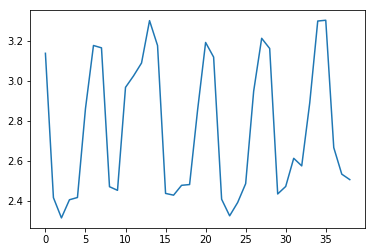

In [31]:
plt.plot(testpreds[129])

In [32]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [33]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              1.643236   
air_0164b9927d20bcc3_2017-04-23              1.434124   
air_0241aa3964b7f861_2017-04-23              2.398040   
air_0328696196e46f18_2017-04-23              2.116699   
air_034a3d5b40d5b1b1_2017-04-23              3.543668   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   4.171877  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   3.195970  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23  10.001590  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   7.303678  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  33.593559

In [34]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [35]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [36]:
submission.to_csv("../submission/l5_3006_xgb_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')